In [9]:
!bash

bash: cannot set terminal process group (64): Inappropriate ioctl for device
bash: no job control in this shell
/content/Network# cd DATASET
/content/Network/DATASET# mv -r DATASET/* .
mv: invalid option -- 'r'
Try 'mv --help' for more information.
/content/Network/DATASET# mv •DATASET/* .
mv: cannot stat '•DATASET/*': No such file or directory
/content/Network/DATASET# mv •DATASET/* .
mv: cannot stat '•DATASET/*': No such file or directory
/content/Network/DATASET# mv DATASET/* .
/content/Network/DATASET# ls
appa-real-release  feature_test.npy   feature_val.npy  valid      val.txt
DATASET            feature_train.npy  train.txt        valid.tar
/content/Network/DATASET# rm DATASET
rm: cannot remove 'DATASET': Is a directory
/content/Network/DATASET# rm -r DATASET
/content/Network/DATASET# exit
exit


# Age Estimation
In this lab, we will implement our own designed Convolutional Neural Network(CNN).

First please download image dataset(APPA-REAL DATABASE) from http://chalearnlap.cvc.uab.es/dataset/26/data/45/description/, and unzip it. Copy this folder to DATASET. The files struction should looks like:

```
-----Network
    |
    |---- DATASET
    |    |-- appa-real-release
    |    |-- valid
    |    |-- feature_test.npy
    |    |-- feature_train.npy
    |    ...
    |---- helperP.pyc
    |---- helperT.pyc
    |---- ignore_list.csv
    |---- networkCustom.ipynb
    |---- pynetworkHidden.ipynb
           
           
           
```

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/Network


'__pycache__/helperT.cpython-37.pyc'

In [7]:
%cd /content/Network/
import py_compile
py_compile.compile(r'helperT.py')

/content/Network


'__pycache__/helperT.cpython-37.pyc'

In [5]:
import os
import numpy as np
from helperT import *

# Loading Data
At the heart of PyTorch data loading utility is the torch.utils.data.DataLoader class. It represents a Python iterable over a dataset. The function will return `train_loader`, `val_loader` and `test_loader` three data loaders. The training dataset has 3,995 labeled images, validation dataset has 1,500 labeled images, and testing dataset has 500 imgages, all of these are collected from APPA Dataset.

In the transform function, we will randomly add some Gaussian blur and noise, random flip, crop, rotate also added to traning and validation process. Don't worry, we have already integrated these for you. You can just using an python `enumerate` function to iterate those datasets.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


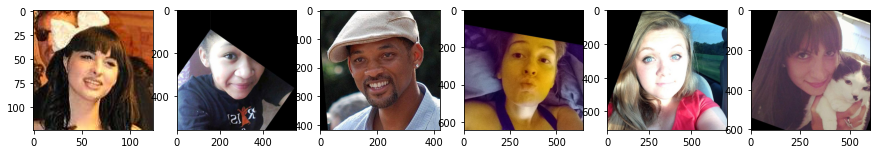

In [10]:
base_dir = '/content/Network/DATASET/'
train_loader, val_loader, test_loader = get_img_dataloaders(base_dir)
show_data(base_dir)

# Network Structure
The torch.nn  module is the cornerstone of designing neural networks in PyTorch. This class can be used to implement a layer like a fully connected layer, a convolutional layer, a pooling layer, an activation function, and also an entire neural network by instantiating a torch.nn.Module object. 

The nn.Module class has two methods that you have to override.

- `__init__ `function. This function is invoked when you create an instance of the nn.Module. Here you will define the various parameters of a layer such as filters, kernel size for a convolutional layer, dropout probability for the dropout layer.
- `forward` function. This is where you define how your output is computed. This function doesn't need to be explicitly called, and can be run by just calling the nn.Module instance like a function with the input as it's argument.

Another widely used and important class is the nn.Sequential class.  When initiating this class we can pass a list of nn.Module objects in a particular sequence. The object returned by nn.Sequential is itself a nn.Module object. When this object is run with an input, it sequentially runs the input through all the nn.Module object we passed to it, in the very same order as we passed them.

After we defined our computing graph, we have to intitialize our networks's weights. You could try with Xavier initialization, or Kaiming initialization. If you want to get a better score in the end, adding batch normalization to the convolution layers is a good choice.

Here's some class or function might be useful for you:
- `nn.Conv2d()`
- `nn.MaxPool2d()`
- `nn.Sequential()`
- `nn.AdaptiveAvgPool2d()`
- `nn.Linear()`
- `nn.ReLU()`
- `nn.Dropout()`


Our CNN network designed as structure below:

| Layer name | kernel size | padding | activation | stride | (fan_in,fan_out) |
| ---------- | ----------- | ------- | ---------- | ------ | ---------------- |
| CONV64     | 7           | 3       | ReLU       |        |       (3,64)     |
| maxpool    | 2           |         |            | 2      |                  |
| CONV128-1  | 5           | 2       | ReLU       |        |     (64,128)     |
| CONV128-2  | 5           | 2       | ReLU       |        |    (128,128)     |
| maxpool    | 2           |         |            | 2      |                  |
| CONV256-1  | 3           | 1       | ReLU       |        |    (128,256)     |
| CONV256-2  | 3           | 1       | ReLU       |        |    (256,256)     |
| CONV256-3  | 3           | 1       | ReLU       |        |    (256,256)     |
| maxpool    | 2           |         |            | 2      |                  |
| CONV512-1  | 3           | 1       | ReLU       |        |    (256,512)     |
| CONV512-2  | 3           | 1       | ReLU       |        |    (512,512)     |
| CONV512-3  | 3           | 1       | ReLU       |        |    (512,512)     |
| maxpool    | 2           |         |            | 2      |                  |
| CONV512-4  | 3           | 1       | ReLU       |        |    (512,512)     |
| CONV512-5  | 3           | 1       | ReLU       |        |    (512,512)     |
| CONV512-6  | 3           | 1       | ReLU       |        |    (512,512)     |
| maxpool    | 2           |         |            | 2      |                  |
| FC1        |             |         | ReLU       |        |  (512x4x4,4096)  |
| FC2        |             |         | ReLU       |        |    (4096,4096)   |
| FC3        |             |         |            |        |    (4096,101)    |

In [11]:
'''
 INPUTS   ---------------->  128x128x64  ---------------->  64x64x64   
128x128x3     CONV-64              maxpool                       

  ---------------->  64x64x128   ---------------->  64x64x128  ---------------->  32x32x128
    CONV128-1             CONV128-2             maxpool
  
  ---------------->  32x32x256   ---------------->  32x32x256   ---------------->  32x32x256  ---------------->  16x16x256
    CONV256-1             CONV256-2             CONV256-3             maxpool
       
  ---------------->  16x16x512   ---------------->  16x16x512   ---------------->  16x16x512  ---------------->   8x8x512
    CONV512-1             CONV512-2             CONV512-3             maxpool

  ---------------->    8x8x512   ---------------->   8x8x512  ---------------->   8x8x512   ---------------->   4x4x512
    CONV512-4             CONV512-5             CONV512-6             maxpool
  
  4x4x512 ----------->  FC1  -----------> FC2  ----------->  FC3
              4096        4096          101

'''

'\n INPUTS   ---------------->  128x128x64  ---------------->  64x64x64   \n128x128x3     CONV-64              maxpool                       \n\n  ---------------->  64x64x128   ---------------->  64x64x128  ---------------->  32x32x128\n    CONV128-1             CONV128-2             maxpool\n  \n  ---------------->  32x32x256   ---------------->  32x32x256   ---------------->  32x32x256  ---------------->  16x16x256\n    CONV256-1             CONV256-2             CONV256-3             maxpool\n       \n  ---------------->  16x16x512   ---------------->  16x16x512   ---------------->  16x16x512  ---------------->   8x8x512\n    CONV512-1             CONV512-2             CONV512-3             maxpool\n\n  ---------------->    8x8x512   ---------------->   8x8x512  ---------------->   8x8x512   ---------------->   4x4x512\n    CONV512-4             CONV512-5             CONV512-6             maxpool\n  \n  4x4x512 ----------->  FC1  -----------> FC2  ----------->  FC3\n              4

In [12]:
class AgeNet(nn.Module):
        def __init__(self):
            super(AgeNet, self).__init__()
            layers = []
            in_channels = 3
            layers += [nn.Conv2d(in_channels, 64, kernel_size=7, padding=3), nn.ReLU()]
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            layers += [nn.Conv2d(64, 128, kernel_size=5, padding=2), nn.ReLU()]
            layers += [nn.Conv2d(128, 128, kernel_size=5, padding=2), nn.ReLU()]
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            layers += [nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU()]
            layers += [nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU()]
            layers += [nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU()]
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            layers += [nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.ReLU()]
            layers += [nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU()]
            layers += [nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU()]
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            layers += [nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU()]
            layers += [nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU()]
            layers += [nn.Conv2d(512, 512, kernel_size=3, padding=1), nn.ReLU()]
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            layers = nn.Sequential(*layers)
            self.features = layers
            self.classifier = nn.Sequential(
                nn.Linear(512 * 4 * 4, 4096),
                nn.ReLU(),
                # nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(),
                # nn.Dropout(),
                nn.Linear(4096, 101),
            )
            self._initialize_weights()

        def forward(self, x):
            x = self.features(x)
            # x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, 0, 0.01)
                    nn.init.constant_(m.bias, 0)



# Training and validation

In [13]:
def train_ageNet():
    ##########################################################################
    # TODO: YOUR CODE HERE
    ##########################################################################   
    # Instantiate the AgeNet
    model = AgeNet()
    print(model)

    # Move the model to gpu (if you have)
    model = model.cuda()

    # Define the optimizer
    EPOCH  = 100
    TRAIN_LR = 0.001   #Learning rate
    MOMENTUM = 0.9    #SGD Momemutm
    optimizer = torch.optim.SGD(model.parameters(), 
                  lr=TRAIN_LR,
                  momentum=MOMENTUM)
    
    # Define the creterion
    criterion = torch.nn.CrossEntropyLoss().cuda()

    # Set the intial value for validation error
    loss_opt = 1e6

    for e in range(EPOCH):
        # Training
        model.train()

        ##########################################################################
        # TODO: YOUR CODE HERE
        ########################################################################## 
        for i, (y, x) in enumerate(train_loader):
            x, y = x.cuda(), y.cuda().long()
            outputs = model(x)
            loss = criterion(outputs, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        ##########################################################################
        # TODO: YOUR CODE HERE
        ########################################################################## 
        # Validationu
        model.eval()
        gtsVal = []
        predsVal = []

        for i, (y, x) in enumerate(val_loader):
            x, y = x.cuda(), y.cuda().long()
            outputs = model(x)
            loss = criterion(outputs, y)
            curr_loss = loss.item()

            predsVal.append(F.softmax(outputs, dim=-1).cpu().detach().numpy())
            gtsVal.append(y.cpu().numpy())

        ##########################################################################
        # TODO: YOUR CODE HERE
        ########################################################################## 
        preds = np.concatenate(predsVal, axis=0)
        ages = np.arange(0, 101)
        predsVal = (preds * ages).sum(axis=-1)
        gtsVal = np.concatenate(gtsVal, axis=0)
        diff = predsVal.reshape(-1,1) - gtsVal.reshape(-1,1)
        mae = np.abs(diff).mean()

        ##########################################################################
        # TODO: YOUR CODE HERE
        ########################################################################## 
        if(mae < loss_opt):
            loss_opt = mae
            torch.save(model,'agenet.pkl')


        #         scheduler.step()
        print(f"=> [epoch {e + 1:04d}] mae validation: {mae:.5f} loss: {curr_loss:.3f}")

    print("=> training finished")
    return predsVal, gtsVal



True
AgeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


=> [epoch 0001] mae validation: 11.91002 loss: 3.804
=> [epoch 0002] mae validation: 11.68526 loss: 3.683
=> [epoch 0003] mae validation: 11.94539 loss: 3.623
=> [epoch 0004] mae validation: 11.42407 loss: 3.683
=> [epoch 0005] mae validation: 12.00875 loss: 3.822
=> [epoch 0006] mae validation: 12.30841 loss: 3.741
=> [epoch 0007] mae validation: 11.47313 loss: 3.519
=> [epoch 0008] mae validation: 11.70700 loss: 3.685
=> [epoch 0009] mae validation: 12.08714 loss: 3.848
=> [epoch 0010] mae validation: 11.73770 loss: 3.768
=> [epoch 0011] mae validation: 11.41627 loss: 3.657
=> [epoch 0012] mae validation: 11.87910 loss: 3.735
=> [epoch 0013] mae validation: 11.73639 loss: 3.779
=> [epoch 0014] mae validation: 11.84433 loss: 3.752
=> [epoch 0015] mae validation: 11.60029 loss: 3.753
=> [epoch 0016] mae validation: 11.07631 loss: 3.459
=> [epoch 0017] mae validation: 11.26391 loss: 3.423
=> [epoch 0018] mae validation: 11.32330 loss: 3.590
=> [epoch 0019] mae validation: 11.72629 loss:

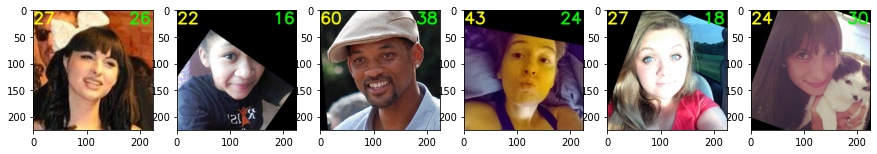

In [14]:
#if __name__ == "__main__":
print(torch.cuda.is_available())
preds, gt = train_ageNet()
show_results(preds, gt)

# Test and Generate results file

In [15]:
model = torch.load('agenet.pkl')
prediction = test_cel(model, test_loader, "custom.txt")
print("Test results has saved to custom.txt")
print(prediction[:10])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test results has saved to custom.txt
[15.00722536 60.0777128  46.21442381 19.0455288  19.58288203 30.57215633
 34.16852231 45.94432947 25.16034107 55.67176913]
